<a href="https://colab.research.google.com/github/mkbensalah/Change-Detection-in-Hyperspectral-Images/blob/master/Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Training with Hermiston Datasets ###

In [1]:
import os
import random
import itertools
from random import shuffle
import h5py
import json
import tensorflow as tf

import numpy as np
import scipy
import scipy.io as sio # Scipy input and output
import scipy.ndimage 
from skimage.transform import rotate 
import spectral # Module for processing hyperspectral image data.
import matplotlib 
%matplotlib inline

# scikit-learn imports 
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix

# keras imports 
#import keras
import tensorflow as tf
from tensorflow.keras import layers, Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, LeakyReLU
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ConvLSTM2D, TimeDistributed
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
import sys

In [2]:
from tensorflow_addons.layers import InstanceNormalization
from tensorflow.keras.layers import Dense, Conv1D, Activation, Flatten, Input, Reshape, LeakyReLU
from tensorflow.keras import Model, Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

from  IPython import display
import pathlib
import shutil
import tempfile
import math
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import os
import numpy as np
from os.path import join, exists, basename, split
from spectral import *

from os import listdir
from os.path import isfile, join
from os import walk
import glob
from sklearn.model_selection import train_test_split
from spectral import *

print(tf.__version__)

C:\Users\CVR 2019 2020\AppData\Roaming\Python\Python36\site-packages\tensorflow_addons\utils\ensure_tf_install.py:68: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.3.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.3.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


2.3.0


In [22]:
def  load_dataset(dataset):
    """load dataset parameters from config.json"""
    dataset = str(dataset)
    print(dataset)
    with open("C:/Users/CVR 2019 2020/hyperspectral_custom/Change-Detection-in-Hyperspectral-Images/Config/config.json") as f:
        config = json.loads(str(f.read()))
        params = config[dataset]
        data_1 = sio.loadmat(params['img_path_1'])['Data2009']
        data_2 = sio.loadmat(params['img_path_2'])['Data2015']
        labels = sio.loadmat(params['gt_path'])['GT_end']

    return data_1, data_2, labels

In [102]:
river_before = sio.loadmat(r"C:\Users\CVR 2019 2020\hyperspectral_custom\Change-Detection-in-Hyperspectral-Images\Dataset\river_before.mat")['river_before']
river_after = sio.loadmat(r"C:\Users\CVR 2019 2020\hyperspectral_custom\Change-Detection-in-Hyperspectral-Images\Dataset\river_after.mat")['river_after']
river_gt = sio.loadmat(r"C:\Users\CVR 2019 2020\hyperspectral_custom\Change-Detection-in-Hyperspectral-Images\Dataset\groundtruth.mat")['lakelabel_v1']

In [29]:
print(river_before.shape)
print(river_after.shape)
print(river_gt.shape)

(463, 241, 198)
(463, 241, 198)
(463, 241)


In [168]:
np.unique(river_gt, return_counts=True)

(array([  0, 255], dtype=uint8), array([101885,   9698], dtype=int64))

In [103]:
print(river_before.min())
print(river_before.max())
print(river_before.mean())

-142
7960
908.0435871128046


In [105]:
def normalize_spectra(spectralInput_1):
    X_manual_scaled1 = (spectralInput_1 - spectralInput_1.min()) / (spectralInput_1.max() - spectralInput_1.min());
    return X_manual_scaled1;

In [106]:
river_before = normalize_spectra(river_before);
river_after = normalize_spectra(river_after);
#river_gt = normalize_spectra(river_gt);

In [108]:
print(river_after.min())
print(river_after.max())
print(river_after.mean())

0.0
1.0
0.13687919037863422


c:\users\cvr 2019 2020\anaconda3\envs\tf2\lib\site-packages\spectral\graphics\spypylab.py:905: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  self.class_axes = plt.imshow(self.class_rgb, **kwargs)


ImageView object:
  Interpolation       :  <default>

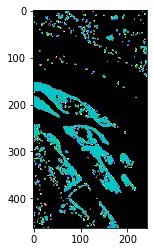

In [156]:
spectral.imshow(classes= river_gt)

In [109]:
print(river_before.min())
print(river_before.max())
print(river_before.mean())
print(river_after.min())
print(river_after.max())
print(river_after.mean())
print(river_gt.min())
print(river_gt.max())
print(river_gt.mean())

0.0
1.0
0.1296030100114543
0.0
1.0
0.13687919037863422
0
255
22.16278465357626


In [110]:
def apply_pca(X, num_components=75):
    """apply pca to X and return new_X"""
    
    new_X = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=num_components, whiten=True)
    new_X = pca.fit_transform(new_X)
    new_X = np.reshape(new_X, (X.shape[0], X.shape[1], num_components))
    return new_X, pca

In [111]:
def pad_with_zeros(X, margin=2):
    """apply zero padding to X with margin"""
    
    new_X = np.zeros(((X.shape[0] + 2*margin), (X.shape[1] + 2*margin), X.shape[2]))
    x_offset = margin
    y_offset = margin
    new_X[(x_offset):(X.shape[0]+x_offset), (y_offset):(X.shape[1]+y_offset), :] = X
    return new_X

In [135]:
def create_patches(X, y, window_size=7, remove_zero_labels = True):
    """create patch from image. suppose the image has the shape (w,h,c) then the patch shape is
    (w*h,window_size,window_size,c)"""
    
    m = margin = int((window_size - 1) / 2);#Just to shorten variable name
    w = window_size;#Just to shorten variable name
    s = 20;#strides
    zero_padded_X = pad_with_zeros(X, margin=margin)
    # split patches
    new_row = int((X.shape[0] + 2*m - w)/s) + 1;# Size after convolution
    new_col = int((X.shape[1] + 2*m - w)/s) + 1;# Size after convolution
    patches_data = np.zeros((new_row*new_col, window_size, window_size, X.shape[2]));#Determined by s, w, p
    print(patches_data.shape);
    patches_labels = np.zeros(new_row*new_col)
    patch_index = 0
    for r in range(margin, (zero_padded_X.shape[0]-margin), s):
        for c in range(margin, (zero_padded_X.shape[1]-margin), s):
            patch = zero_padded_X[(r-margin):(r+margin+1), (c-margin):(c+margin+1)]   
            patches_data[patch_index, :, :, :] = patch
            patches_labels[patch_index] = y[r-margin, c-margin] + 1
            patch_index = patch_index+1
            
    if remove_zero_labels:
        patches_data = patches_data[patches_labels>0,:,:,:]
        patches_labels = patches_labels[patches_labels>0]
        patches_labels -= 1
    return patches_data, patches_labels

In [113]:
def split_train_test_set(X, y, test_ratio=0.10):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=345,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [114]:
def oversample_weak_classes(X, y):
    """"balance the dataset by prforming oversample of weak classes (making each class have close labels_counts)"""
    unique_labels, labels_counts = np.unique(y, return_counts=True)
    
    print(unique_labels.shape)
    print(unique_labels)
    print(labels_counts.shape)
    print(labels_counts)
    max_count = np.max(labels_counts)
    labels_inverse_ratios = max_count / labels_counts  
    #print(labels_inverse_ratios)
    # repeat for every label and concat
    print(labels_inverse_ratios)
    new_X = X[y == unique_labels[0], :, :, :].repeat(round(labels_inverse_ratios[0]), axis=0)
    new_Y = y[y == unique_labels[0]].repeat(round(labels_inverse_ratios[0]), axis=0)
    for label, labelInverseRatio in zip(unique_labels[1:], labels_inverse_ratios[1:]):
        cX = X[y== label,:,:,:].repeat(round(labelInverseRatio), axis=0)
        cY = y[y == label].repeat(round(labelInverseRatio), axis=0)
        new_X = np.concatenate((new_X, cX))
        new_Y = np.concatenate((new_Y, cY))
    np.random.seed(seed=42)
    rand_perm = np.random.permutation(new_Y.shape[0])
    new_X = new_X[rand_perm, :, :, :]
    new_Y = new_Y[rand_perm]
    unique_labels, labels_counts = np.unique(new_Y, return_counts=True)
    
#     print(unique_labels.shape)
#     print(unique_labels)
#     print(labels_counts.shape)
#     print(labels_counts)
    return new_X, new_Y

In [115]:
def augment_data(X_train):
    """augment the data by taking each patch and randomly performing 
    a flip(up/down or right/left) or a rotation"""
    
    for i in range(int(X_train.shape[0]/2)):
        patch = X_train[i,:,:,:]
        num = random.randint(0,2)
        if (num == 0):
            
            flipped_patch = np.flipud(patch)
        if (num == 1):
            
            flipped_patch = np.fliplr(patch)
        if (num == 2):
            
            no = random.randrange(-180,180,30)
            flipped_patch = scipy.ndimage.interpolation.rotate(patch, no,axes=(1, 0),
                                                               reshape=False, output=None, order=3, mode='constant', cval=0.0, prefilter=False)
    
    
        patch2 = flipped_patch
        X_train[i,:,:,:] = patch2
    
    return X_train

In [116]:
#Parameters
dataset = "Hermiston" # Indian_pines or PaviaU or or Salinas  . check config.json
window_size = 21;#Kernel size
num_pca_components = 30
test_ratio = 0.25

In [146]:
X_1, X_2, y = [river_before, river_after, river_gt]
print(X_1.shape)
print(X_2.shape)

(463, 241, 198)
(463, 241, 198)


#### Preprocessing for the first image ####

In [139]:
X_1, pca = apply_pca(X_1, num_pca_components)
X_1.shape

(463, 241, 30)

In [140]:
X_1.shape

(463, 241, 30)

In [141]:
X_1_patches, y_patches = create_patches(X_1, y, window_size=window_size);
print(X_1_patches.shape);
print(y_patches.shape);

(312, 21, 21, 30)
(312, 21, 21, 30)
(312,)


In [142]:
y_patches

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0., 255.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 255.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0., 255., 255.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 255., 255.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 255., 255.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   

In [157]:
X_1_train, X_1_test, y_1_train, y_test = split_train_test_set(X_1_patches, y_patches, test_ratio)
X_1_train.shape

(234, 21, 21, 30)

In [158]:
X_1_train, y_1_train = oversample_weak_classes(X_1_train, y_1_train)
print(X_1_train.shape)
X_1_train = augment_data(X_1_train)
X_1_train.shape

(2,)
[  0. 255.]
(2,)
[214  20]
[ 1.  10.7]
(434, 21, 21, 30)


(434, 21, 21, 30)

#### Do the same for the second data ####

In [147]:
X_2,pca = apply_pca(X_2, num_pca_components)
X_2_patches, y_patches = create_patches(X_2, y, window_size=window_size)
X_2_train, X_2_test, y_train, y_test = split_train_test_set(X_2_patches, y_patches, test_ratio)
X_2_train, y_train = oversample_weak_classes(X_2_train, y_train)
X_2_train = augment_data(X_2_train)
X_2_train.shape

(312, 21, 21, 30)
(2,)
[  0. 255.]
(2,)
[214  20]
[ 1.  10.7]


(434, 21, 21, 30)

#### Some preprocessing for the lables (Groundtruth change) ####

In [148]:
y_train = np_utils.to_categorical(y_train) # convert class labels to on-hot encoding
y_test = np_utils.to_categorical(y_test)
y_train = y_train[:,-1]

In [149]:
y_train

array([1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1.,
       0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1.,
       0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1.,
       0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1.,
       0., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0.,
       0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1.,
       1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1.,
       1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1.,
       1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1.,
       1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 1., 1., 1., 1.

In [150]:
print(X_1_train.shape)
print(X_1_train.ndim)
print(X_2_train.shape)
print(X_2_train.ndim)
print(y_train.shape)
print(y_train.ndim)

(434, 21, 21, 30)
4
(434, 21, 21, 30)
4
(434,)
1


In [159]:
print(X_1_train[0].shape)

(21, 21, 30)


In [176]:
(sys.getsizeof(X_1_train))/(1048576)

43.80674743652344

In [154]:
data = np.zeros(shape=(434, 2, 21, 21, 30)); # batches of paris of patches of size (21, 21, 30) 
labels = np.zeros(shape=(434, 1))
labels = y_train
# Is it just a redundancy? Why not start the loop from 0
data_1 = np.array([X_1_train[0], X_2_train[0]]);# Form pairs of data
data[0] = data_1

for i in range(1, 434):
  x = np.array([X_1_train[i], X_2_train[i]]);
  data[i] = x;
    
print(data.shape);
print(data.ndim);

print(y_train.shape);
print(y_train.ndim);

(434, 2, 21, 21, 30)
5
(434,)
1


In [177]:
(sys.getsizeof(data))/(1048576)

87.61337280273438

In [181]:
def define_model():
    
    
    input_shape= X_1_train[0].shape # Define the input shape (21x21x30). What's the point?
    C1 = 3 * num_pca_components # number of filters
    
    model = Sequential()
    model.add(TimeDistributed(Conv2D(C1, (3, 3), padding='same', activation='relu'), input_shape=(2, 21, 21, 30)))
    model.add(TimeDistributed(MaxPooling2D(2,2)))
    model.add(TimeDistributed(Conv2D(3 * C1, (3, 3), padding='same', activation='relu')))
    model.add(ConvLSTM2D(16, kernel_size = (3, 3),padding = 'same', return_sequences = True))
    model.add(ConvLSTM2D(32, kernel_size = (3, 3), padding = 'same', return_sequences = False))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    
    print(input_shape)
    sgd = SGD(lr=0.01, decay=1e-3, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [182]:
model = define_model()

model.summary()

(21, 21, 30)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_6 (TimeDist (None, 2, 21, 21, 90)     24390     
_________________________________________________________________
time_distributed_7 (TimeDist (None, 2, 10, 10, 90)     0         
_________________________________________________________________
time_distributed_8 (TimeDist (None, 2, 10, 10, 270)    218970    
_________________________________________________________________
conv_lst_m2d_4 (ConvLSTM2D)  (None, 2, 10, 10, 16)     164800    
_________________________________________________________________
conv_lst_m2d_5 (ConvLSTM2D)  (None, 10, 10, 32)        55424     
_________________________________________________________________
flatten_2 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)   

In [167]:
# We have already trained the model
data_1 = np.array([X_1_train[0], X_1_train[1]])

data_2= np.array([X_1_train[2], X_1_train[3]])

data = np.array([data_1, data_2])

print(data.shape)
print(data.ndim)
labels =np.array([y_train[0], y_train[1]])
print(labels.shape)
print(labels.ndim)

(2, 2, 21, 21, 30)
5
(2,)
1


In [183]:
model.fit(data, labels, batch_size=32, epochs=100)

Epoch 1/100
14/14 [==============================] - 1s 39ms/step - loss: 0.6932 - accuracy: 0.4700
Epoch 2/100
14/14 [==============================] - 1s 38ms/step - loss: 0.6933 - accuracy: 0.4562
Epoch 3/100
14/14 [==============================] - 1s 39ms/step - loss: 0.6933 - accuracy: 0.5069
Epoch 4/100
14/14 [==============================] - 1s 39ms/step - loss: 0.6931 - accuracy: 0.5069
Epoch 5/100
14/14 [==============================] - 1s 39ms/step - loss: 0.6931 - accuracy: 0.5069
Epoch 6/100
14/14 [==============================] - 1s 39ms/step - loss: 0.6933 - accuracy: 0.5069
Epoch 7/100
14/14 [==============================] - 1s 39ms/step - loss: 0.6931 - accuracy: 0.5069
Epoch 8/100
14/14 [==============================] - 1s 38ms/step - loss: 0.6932 - accuracy: 0.5069
Epoch 9/100
14/14 [==============================] - 1s 40ms/step - loss: 0.6934 - accuracy: 0.4793
Epoch 10/100
14/14 [==============================] - 1s 40ms/step - loss: 0.6934 - accuracy: 0.5069

In [169]:
model.save('trained_model_river.h5')

In [163]:
print(model.layers[2])

In [184]:
X_1, X_2, y = [hermi_2004, hermi_2007, hermi_gt]
X_1,pca = apply_pca(X_1,num_pca_components)
X_2,pca = apply_pca(X_2,num_pca_components)
height = y.shape[0]
width = y.shape[1]
patch_size = window_size
data = np.zeros(shape=(434, 2, 21, 21,30))
data_1 = np.array([X_1, X_2])
X = X_1
print(X_1.shape)
print(x.ndim)

(463, 241, 30)
4


In [185]:
def get_patch(data,height_index,width_index):
    #transpose_array = data.transpose((2,0,1))
    #print transpose_array.shape
    height_slice = slice(height_index, height_index+patch_size)
    width_slice = slice(width_index, width_index+patch_size)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [186]:
def generate_pridected_image():
    """generate the predicted image"""
    outputs = np.zeros((height,width))

    for i in range(height-patch_size+1):
        for j in range(width-patch_size+1):
            target = y[int(i+patch_size/2), int(j+patch_size/2)]
            if target == 0 :
                continue
            else :
                image_patch=get_patch(X,i,j)
                X_test_image = image_patch.reshape(21,21,30).astype('float32')
                image_patch=get_patch(X_2,i,j)
                X_2_test_image = image_patch.reshape(21,21,30).astype('float32')
                
                X_F = np.array([X_test_image, X_2_test_image])
                X_2_F = X_F.reshape(1,X_F.shape[0],X_F.shape[1],X_F.shape[2],X_F.shape[3])
                
                prediction = (model.predict_classes(X_2_F))                         
                outputs[int(i+patch_size/2)][int(j+patch_size/2)] = prediction+1
    return outputs.astype(int)

In [ ]:
outputs=generate_pridected_image()
predict_image = spectral.imshow(classes = outputs.astype(int), figsize =(7,7))

In [ ]:
gt_image = spectral.imshow(classes = y,figsize =(7,7))

In [ ]:
spectral.imshow(hermi_2004, bands = (29, 19, 9))

In [ ]:
spectral.imshow(hermi_2007, bands = (29, 19, 9))

### Outputs after normalization ###

c:\users\cvr 2019 2020\anaconda3\envs\tf2\lib\site-packages\spectral\graphics\spypylab.py:905: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  self.class_axes = plt.imshow(self.class_rgb, **kwargs)


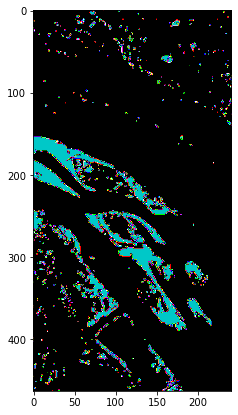

In [147]:
gt_image = spectral.imshow(classes = hermi_gt,figsize =(7,7));

ImageView object:
  Display bands       :  (29, 19, 9)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.13762034065662798, 0.6513206615650456]
    G: [0.20229572944951862, 0.907923969390274]
    B: [0.2891878548506542, 0.9198963218958282]

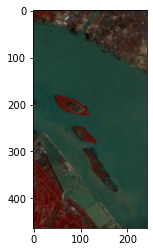

In [148]:
spectral.imshow(hermi_2004, bands = (29, 19, 9))

ImageView object:
  Display bands       :  (29, 19, 9)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.17660747091243112, 0.5970606246172688]
    G: [0.2353949785670545, 0.7783221065523577]
    B: [0.31916717697489283, 0.7611757501530925]

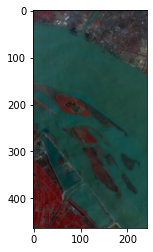

In [149]:
spectral.imshow(hermi_2007, bands = (29, 19, 9))

In [22]:
theInput = Input((2, 64, 64, 32))

convLSTM = TimeDistributed(Conv2D(64, (5, 5), padding='same', activation=LeakyReLU()))(theInput)
convLSTM = TimeDistributed(Conv2D(32, (3, 3), padding='same', activation=LeakyReLU()))(convLSTM)
convLSTM = ConvLSTM2D(32, kernel_size = (3, 3),padding = 'same', return_sequences = True)(convLSTM)
convLSTM = ConvLSTM2D(16, kernel_size = (3, 3), padding = 'same', return_sequences = False)(convLSTM)
convLSTM = Dense(6, activation = 'softmax')(convLSTM)

lstm_model = Model(inputs = theInput, outputs = convLSTM);
lstm_model.summary();

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 2, 64, 64, 32)]   0         
_________________________________________________________________
time_distributed_14 (TimeDis (None, 2, 64, 64, 64)     51264     
_________________________________________________________________
time_distributed_15 (TimeDis (None, 2, 64, 64, 32)     18464     
_________________________________________________________________
conv_lst_m2d_14 (ConvLSTM2D) (None, 2, 64, 64, 32)     73856     
_________________________________________________________________
conv_lst_m2d_15 (ConvLSTM2D) (None, 64, 64, 16)        27712     
_________________________________________________________________
dense_7 (Dense)              (None, 64, 64, 6)         102       
Total params: 171,398
Trainable params: 171,398
Non-trainable params: 0
________________________________________________

In [19]:
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')